That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [164]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [165]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

In [166]:
fname = '/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_None_HSAB.hdf5'

In [167]:
f = h5py.File(fname, 'r')

In [168]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [169]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_hsab_h/PearceWpHSABCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_hsab_h/PearceDsHSABCosmo.hdf5'],
      dtype='|S62')

In [170]:
fixed_params = fixed_params[0]

In [171]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_hsab_h/PearceWpHSABCosmo.hdf5
3
/u/ki/swmclau2/des/Aemulators/ds_hsab_h/PearceDsHSABCosmo.hdf5
3


In [172]:
chain_pnames = f.attrs['param_names']

In [173]:
n_walkers = f.attrs['nwalkers']

In [174]:
n_burn = 0
chain = f['chain'][n_burn*n_walkers:, :]

In [175]:
rmin = 0#eval(f.attrs['fixed_params'])['rmin']

In [176]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [177]:
print chain.shape, chain.shape[0]/n_walkers

(2685000, 14) 10740


In [178]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [179]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.36167575e-02  1.11538666e-01 -5.68055247e-01  9.64994687e-01
  6.83596452e+01  3.35523986e+00  8.84990324e-01  3.54276198e-01
  1.34779514e+01  1.01564681e-01 -5.63577951e-01  1.41656172e+01
  9.74348989e-01  1.11432751e+00]


In [180]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_param1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [181]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [182]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [183]:
MAP_dict.update(fixed_params)

In [184]:
MAP_dict

{'H0': 68.35964523289064,
 'Neff': 3.3552398581363034,
 'alpha': 0.974348989400724,
 'conc_gal_bias': 1.1143275138435453,
 'logM0': 13.47795138617279,
 'logM1': 14.165617194965174,
 'mean_occupation_centrals_assembias_param1': 0.3542761982756695,
 'mean_occupation_satellites_assembias_param1': -0.5635779514278236,
 'ns': 0.9649946865945437,
 'ombh2': 0.023616757458923544,
 'omch2': 0.11153866595568912,
 'sigma8': 0.8849903241445188,
 'sigma_logM': 0.10156468091684095,
 'w0': -0.5680552465778789,
 'z': 0.0}

In [185]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [186]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [187]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [188]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [189]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 1

In [190]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [191]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [192]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [193]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 0.8, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [194]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_param1': 0.0,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [195]:
true_data = f['data'][()]#.flatten()

In [196]:
true_data = true_data.reshape((2, -1))

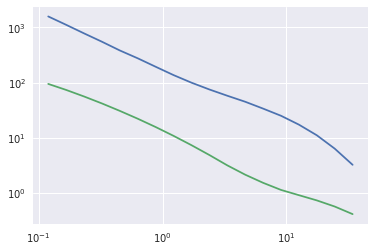

In [197]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [198]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [199]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

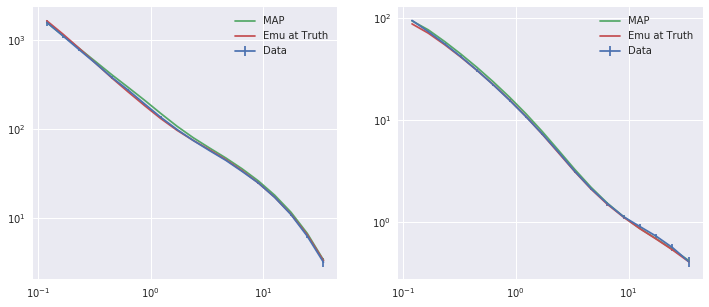

In [200]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

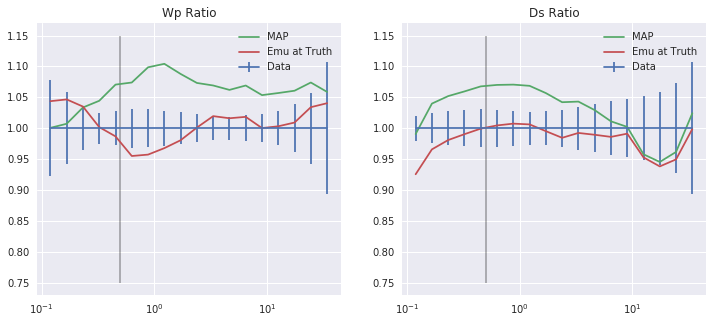

In [201]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    if i == 0:
        plt.title('Wp Ratio')
    else:
        plt.title('Ds Ratio')
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.vlines(0.5, 0.75, 1.15, alpha = 0.3)
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [202]:
for i in xrange(2):
    print true_data2[i]/true_data[i]

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [203]:
emu.obs

'ds'

In [204]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [205]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1', 'logM0', 'sigma_logM',
       'mean_occupation_satellites_assembias_param1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [206]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [207]:
rmin_idxs = rbc > rmin

In [208]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [209]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
3.381677855992913


In [210]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
4.348516710484697


In [211]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [212]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

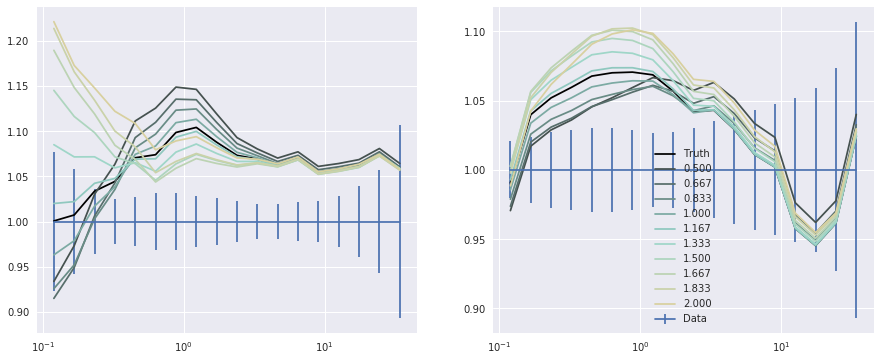

In [213]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'conc_gal_bias'
lower, upper = emu.get_param_bounds(varied_pname)

baseline_params = MAP_dict

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(baseline_params.copy()).squeeze()
    if i ==1:
        const = 1#np.power(MAP_dict['H0']/(100*h), 2)
    else:
        const = 1
    plt.plot(rbc, const*(10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = baseline_params.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        if i ==1:
            const = 1#np.power(val/(100*h), 2)
        else:
            const= 1 #np.power(val/(100*h), 1)
        plt.plot(rbc, const*((10**pred)/(true_data[i])), label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();

In [214]:
assert False

AssertionError: 

In [ ]:
from pearce.mocks.kittens import Chinchilla

In [ ]:
cat = Chinchilla(400, 2048)

In [ ]:
cat.load(1.0, HOD='zheng07')

In [ ]:
from scipy.optimize import minimize_scalar
def add_logMmin(cat, hod_params):
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=20) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [ ]:
add_logMmin(cat, hod_params)
r_bins = np.logspace(-1, 1.6, 19)

In [ ]:
N = 5
wps = np.zeros((N, 18))
for i in xrange(N):
    pritn i
    cat.populate(hod_params, min_ptcl=20)
    wps[i] = cat.calc_wp(r_bins)
    
wp = wps.mean(axis=0)
wp_err = wps.std(axis=0)

In [ ]:
chinchilla_pnames, chinchilla_pvals = cat._get_cosmo_param_names_vals()

In [ ]:
chinchilla_pnames

In [ ]:
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = [chinchilla_pvals[1]*chinchilla_pvals[2]**2, (chinchilla_pvals[0]-chinchilla_pvals[1])*chinchilla_pvals[2]**2,
                   -1, chinchilla_pvals[4], 100*chinchilla_pvals[2], 3.046, chinchilla_pvals[3]]

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [ ]:
params = cat_val_dict.copy()
del hod_params['logMmin']
params.update(hod_params)

In [ ]:
emu_wp = 10**emus[0].emulate_wrt_r(params)[0]

In [ ]:
plt.plot(emu.scale_bin_centers, wp, label = 'Chinchilla')
plt.plot(emu.scale_bin_centers, emu_wp, label = 'Emu')
plt.legend(loc='best')
plt.loglog();

In [ ]:
plt.plot(emu.scale_bin_centers, wp/emu_wp)
plt.errorbar(emu.scale_bin_centers, np.ones_like(wp), yerr = wp_err/wp)
plt.xscale('log')

In [ ]:
plt.hist(cat.model.mock.galaxy_table['conc_NFWmodel'], bins = 100, normed = True);

In [ ]:
from pearce.mocks.kittens import TrainingBox

In [ ]:
cat2 = TrainingBox(0)
cat2.load(1.0, HOD='zheng07')

In [ ]:
add_logMmin(cat2, hod_params)
cat2.populate(hod_params, min_ptcl=20)

In [ ]:
bins = np.linspace(2.5, 20.0, 100)
plt.hist(cat.model.mock.galaxy_table['conc_NFWmodel'], bins = bins, normed = True, alpha = 0.3, label = 'Chinchilla');
plt.hist(cat2.model.mock.galaxy_table['conc_NFWmodel'], bins = bins, normed = True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(-4, 0, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_rs']), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_rs']), bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(-4, 0, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_rvir']), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_rvir']), bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
plt.hist2d(np.log10(cat.halocat.halo_table['halo_mvir']), np.log10(cat.halocat.halo_table['halo_rs']),\
           bins = 100, normed =True);
plt.hist2d(np.log10(cat2.halocat.halo_table['halo_mvir']), np.log10(cat2.halocat.halo_table['halo_rs']+1e-6),\
           bins = 100, normed =True);
plt.xlim([9, 13])
plt.ylim([-3, 0])

In [ ]:
m_min = np.min(cat2.halocat.halo_table['halo_mvir'])*10

In [ ]:
np.log10(m_min)

In [ ]:
mass_cut = np.logical_and(cat.halocat.halo_table['halo_mvir']>10**(12.0), cat.halocat.halo_table['halo_mvir']<10**(14.5))
mass_cut2 = np.logical_and(cat2.halocat.halo_table['halo_mvir']>10**(12.0), cat2.halocat.halo_table['halo_mvir']<10**(14.5)) 

In [ ]:
bins = np.linspace(11, 16, 100)
plt.hist(np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(np.log10(cat2.halocat.halo_table['halo_mvir'])[mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
1./0.01

In [ ]:
bins = np.linspace(1./0.2, 1./0.01, 50)
plt.hist(1./cat.halocat.halo_table['halo_rs'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(1./cat2.halocat.halo_table['halo_rs'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(0.0, 1.0, 100)
plt.hist(cat.halocat.halo_table['halo_rvir'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(cat2.halocat.halo_table['halo_rvir'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')

In [ ]:
bins = np.linspace(2.5, 20, 100)
plt.hist(cat.halocat.halo_table['halo_nfw_conc'][mass_cut], bins = bins, normed=True, alpha = 0.3, label ='Chinchilla');
plt.hist(cat2.halocat.halo_table['halo_nfw_conc'][mass_cut2], bins = bins, normed=True, alpha = 0.3, label = 'Aemulus');
plt.legend(loc='best')
#plt.yscale('log')

In [ ]:
finite_idxs = np.isfinite(cat2.halocat.halo_table['halo_nfw_conc'])
mass_cut2 = np.logical_and(finite_idxs, mass_cut2)

In [ ]:
sns.jointplot(np.log10(cat2.halocat.halo_table['halo_mvir'][mass_cut2]), np.log10(1./cat2.halocat.halo_table['halo_rs'][mass_cut2]), kind='hex')

In [ ]:
sns.jointplot(np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), np.log10(1./cat.halocat.halo_table['halo_rs'][mass_cut]), kind='hex')

In [ ]:
sns.jointplot(cat2.halocat.halo_table['halo_rvir'][mass_cut2], np.log10(cat2.halocat.halo_table['halo_mvir'][mass_cut2]), kind='hex')

In [ ]:
sns.jointplot(cat.halocat.halo_table['halo_rvir'][mass_cut], np.log10(cat.halocat.halo_table['halo_mvir'][mass_cut]), kind='hex')